# Machine Learning final project
---
### Stackoverflow 60k questions
    Student: Douglas Kosvoski - 1911100022

Obs: **It takes a "*few*" minutes to run**

## Loading

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
""" The dataset is avaiable through google sheets api """

# https://docs.google.com/spreadsheets/d/1xdU55aEjDM-gdVWOm1UcSPmE0KcMFG5XHzs-9nyBTEA
sheet_id = "1xdU55aEjDM-gdVWOm1UcSPmE0KcMFG5XHzs-9nyBTEA"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet="

df_data = pd.read_csv(url + 'train').drop(['Id', 'CreationDate'], axis=1)
df_test = pd.read_csv(url + 'valid').drop(['Id', 'CreationDate'], axis=1)

# join train and test into a single dataframe
df = pd.concat([df_test, df_data])

### Analyzing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   60000 non-null  object
 1   Body    60000 non-null  object
 2   Tags    60000 non-null  object
 3   Y       60000 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


### Dealing with NaN/Null values

In [8]:
df.isna().sum()

Title    0
Body     0
Tags     0
Y        0
dtype: int64

## Charts

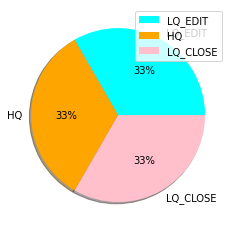

[20000, 20000, 20000]


In [9]:
df.head()

output = []
for i in list(df['Y'].unique()):
  count = (df['Y'] == i).sum()
  output.append(count)

plt.pie(
  output,
  labels  =df['Y'].unique(),
  autopct ='%.0f%%',
  colors  =['cyan', 'orange', 'pink'],
  radius  = 1,
  shadow  = True
)

plt.legend(); plt.show()
print(output)

## NLP

In [10]:
def get_average_feature_length(docs, feature):
  total_size = 0
  max_size = 0
  min_size = 999

  for i in docs:
    length = len(i)
    total_size += length
  
    if length > max_size:
      max_size = length

    if length < min_size:
      min_size = length
    
  print(f"\n{'-'*15} {feature} {'-'*15}")
  print(f"Average length {int(total_size / len(docs))}")
  print(f"Max length {max_size}")
  print(f"Min length {min_size}")
  return int(total_size / len(docs))

avg_title_size = get_average_feature_length(df['Title'], 'Title')
avg_body_size = get_average_feature_length(df['Body'], 'Body')
avg_tag_size = get_average_feature_length(df['Tags'], 'Tags')


--------------- Title ---------------
Average length 53
Max length 150
Min length 7

--------------- Body ---------------
Average length 980
Max length 35288
Min length 7

--------------- Tags ---------------
Average length 25
Max length 112
Min length 3


In [11]:
# Convert from html format to plain text

from bs4 import BeautifulSoup as soup

clean_titles, clean_bodies, clean_tags = [], [], []
r = len(df)

for f in df.columns:
  if f == 'Title':
    for i in df[f][:r]:
      clean_titles.append((soup(i, "lxml").text, len(i)))

  elif f == 'Body':
    for i in df[f][:r]:
      clean_bodies.append((soup(i, "lxml").text, len(i)))

  elif f == 'Tags':
    for i in df[f][:r]:
      clean_tags.append((" ".join(i.replace('>', '').split('<')).strip(), len(i)))

In [12]:
# remove objects where body length is greater than the avg body length

new_titles, new_bodies, new_tags = [], [], []

for i in range(r):
  if not clean_bodies[i][1] > avg_body_size:
    new_titles.append(clean_titles[i][0])
    new_bodies.append(clean_bodies[i][0])
    new_tags.append(clean_tags[i][0])

In [13]:
# before converting to plain text and the removal of rows which body length exceed the avg length
df.head(5)

,Title,Body,Tags,Y
0,How to get all the child records from differen...,I am having 4 different tables like \nselect *...,<sql><sql-server>,LQ_EDIT
1,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,LQ_EDIT
2,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,HQ
3,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,LQ_EDIT
4,php rearrange array elements based on condition,basically i have this array:\n\n array(\n\t...,<php>,LQ_EDIT


In [15]:
# Rejoin all remaining rows to the DataFrame
clean_df = pd.DataFrame()
clean_df['Title'] = new_titles
clean_df['Body'] = new_bodies
clean_df['Tags'] = new_tags
df = clean_df

In [16]:
# After modifications
df.head(5)

,Title,Body,Tags
0,How to get all the child records from differen...,I am having 4 different tables like \nselect *...,sql sql-server
1,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,php mysql sql codeigniter mysqli
2,How do I make a constructor for a derived class?,I am trying to make a constructor for a derive...,c++ inheritance constructor derived-class
3,how can i create a dynamic tow dimensional arr...,I am using c++ in my lesson and for solving a ...,c++
4,Re-exporting ES6 modules in TS 1.7?,I'm getting a bit lost in TS re-exports. Say I...,typescript ecmascript-6 es6-module-loader type...


## Remove Stopwords and punctuation

In [17]:
import spacy

spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [18]:
def convert_to_string(df, feature) -> str:
  output = []
  for i in range(len(df[feature])):
    output.append(df[feature][i].strip())
  return output

def remove_stop_words_and_punctuation(text: str) -> list:
  dlemma = []
  for i in text:
    tdoc = nlp(i)
    lm = " ".join([token.lemma_ for token in tdoc  if not(token.is_stop or token.is_digit or token.is_punct)])
    dlemma.append(lm)
  return dlemma


titles = convert_to_string(df, 'Title')
bodies = convert_to_string(df, 'Body')
tags   = convert_to_string(df, 'Tags')

## bigram

In [19]:
from gensim.models.phrases import Phrases, Phraser

import gensim.utils

In [20]:
dtoken  = [gensim.utils.simple_preprocess(d, deacc= True, min_len=3) for d in titles]
phrases = Phrases(dtoken, min_count=2, threshold=9)
bigram  = Phraser(phrases)
bdocs   = [bigram[d] for d in dtoken]

asd = []
for i in bdocs:
  for j in i:
    asd.append(j)
bigranized = asd

In [24]:
bigrams_list = [i for i in bigranized if '_' in i]
print(len(bigrams_list), bigrams_list[:20])

29210 ['different_tables', 'sql_server', 'derived_class', 'create_dynamic', 'dimensional_array', 'fetch_api', 'form_validation', 'upload_to', 'was_trying', 'indentation_error', 'this_code', 'argument_type', 'telegram_bot', 'hover_effect', 'hover_effect', 'trying_build', 'does_not', 'web_app', 'the_easiest', 'material_design']


## Remove dups

In [31]:
uniques = set(bigranized)
uniques = dict(zip(range(len(uniques)), uniques))

print(len(bigranized), len(uniques))

275230 19554


In [39]:
uniques.values()

dict_values(['optimization', 'cellphone', 'returns_undefined', 'bouncing', 'adamoptimizer', 'malformed', 'keyspace', 'clustered', 'separeted', 'boilerplate', 'prefix', 'yxlwiw', 'date_time', 'plan', 'outlining', 'vsim', 'questions_about', 'icloud', 'static_methods', 'flood', 'deepmind', 'problems_with', 'xxd', 'git_hub', 'prime', 'exention', 'asyncdata', 'apc_fetch', 'powerful', 'secs', 'dobdate', 'josuttis', 'indexable', 'hyper', 'pyparsing', 'statemnt', 'got_this', 'schematic', 'uid', 'badge', 'laziness', 'clickonce', 'singleordefault', 'beginwrite', 'fargate', 'onto', 'coordinate', 'notified', 'alphavantage', 'dropdown_list', 'matploatlib', 'accepted', 'xcodeproj', 'newbie', 'richtextbox', 'angularerror', 'position_relative', 'uncommitted', 'temp', 'meal', 'ethernet', 'windows_authentication', 'repetative', 'highlight', 'wkhtmltopdf', 'chrome_headless', 'report', 'app_pwa', 'getresources', 'suggestions', 'overgrow', 'vueclass', 'formcontrol', 'staitic', 'usecontext', 'typedef', 'tha

## Tokenize

In [ ]:
def tokenize(dlemma):
  max_size = len(dlemma); count = 0
  output = []
  
  for i in dlemma:
    if count % 200 == 0:
      print(f"{count}/{max_size}")
    
    aux = []; doc = nlp(i)

    for token in doc:
      if token.pos_ in ['NOUN', 'PROPN']:
        aux.append(token.lemma_)
    output.append(aux)
    count += 1
  return output
        
tokens = tokenize(uniques.values())
tokens[:10]

In [63]:
# remove empty objects from the tokens

print("Before: ", len(tokens))
clean_tokens = []
for t in tokens:
  if t != []:
    clean_tokens.append(t)
tokens = clean_tokens
print("After: ", len(tokens))

Before:  19554
After:  10485


In [ ]:
tokens

## Metrics

In [65]:
number_of_docs = len(tokens)
number_of_docs

10485

In [88]:
def stats_about_the_docs(docs):
  shortest_doc, largest_doc = "_"*100, ""
  max_size, min_size = 0, 999
  total_size = 0

  for i in docs:
      length = len(i[0])
      total_size += length

      if length > max_size:
        max_size = length
        largest_doc = i[0]

      if length < min_size:
        min_size = length
        shortest_doc = i[0]

  print(f"Average word length: {int(total_size / len(docs))}")
  print(f"\nMax length {max_size} : {largest_doc}")
  print(f"Min length  {min_size} : {shortest_doc}")

stats_about_the_docs(tokens)

Average word length: 7

Max length 22 : transparent_background
Min length  2 : op


In [59]:
def create_single_string(tokens):
  output = ''
  for i in tokens:
    for j in i:
      output += j + " "

  return output

output = create_single_string(tokens)
output

'optimization cellphone adamoptimizer keyspace boilerplate prefix yxlwiw plan vsim icloud static_method flood problems_with xxd git_hub exention asyncdata sec dobdate josuttis statemnt uid badge laziness singleordefault beginwrite alphavantage matploatlib xcodeproj angularerror temp meal ethernet wkhtmltopdf report suggestion overgrow vueclass formcontrol staitic typedef that_determine stanford charterer max_children sphinx q_enum mongolab androidmy comaprison gregorian everyday semantic apim aktiv atomicfu helm antivirus ledger gap prooblem tcharhelper health adword vaiable severity pedestrian division sfml question nhu week fpdf match_word viewer company andriod cql type_annotation currentuser deletion minute formula package_lock extractor keepalive nsdate pcntl chrome_dev practie sshpass male sms parallax eligibility suggestion opinion recovre replace_all filemaker wth nugetscratch session nest verb libfontconfig sill paste junit pca provider power jsonobject vertex shared_preferenc

## Wordcloud

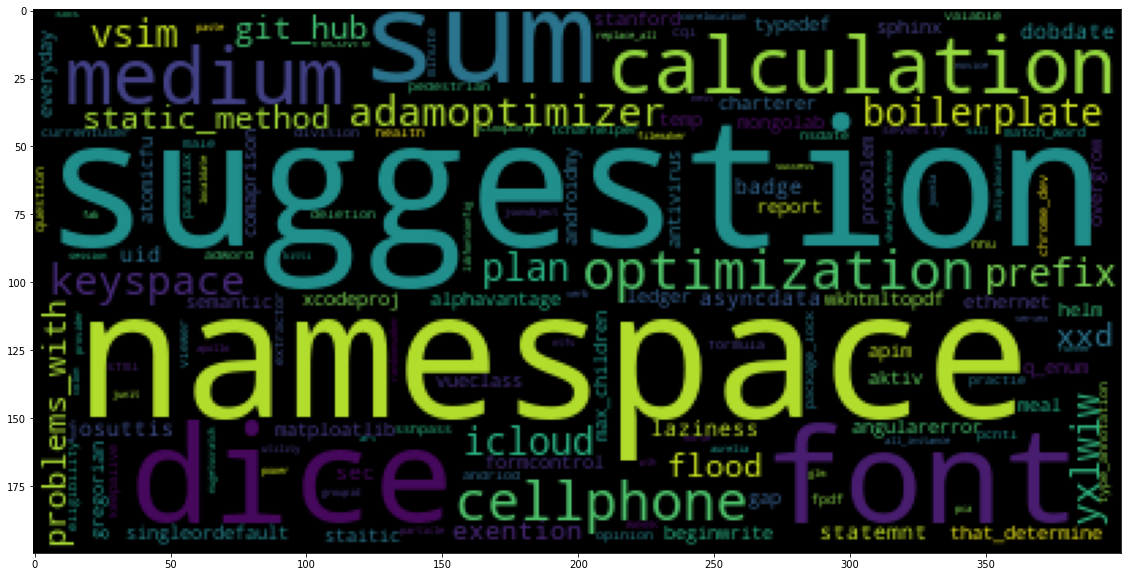

In [93]:
import wordcloud as wc
import matplotlib.pyplot as plt

mycloud = wc.WordCloud().generate(output)
plt.figure(figsize=(20,10))
plt.imshow(mycloud)